## Cassava Leaf Disease Classification

Cassava, grown by smallholder farmers and playing a critical role in food security in Africa, is the continent’s second largest source of carbohydrates. At least 80% of household farms in sub-Saharan Africa grow this starchy root. However, viral diseases are a major cause of low yields. With the help of data science, it may be possible to identify and treat common diseases.

Current disease detection methods require farmers to visually inspect their plants with the help of government-supported agricultural experts. These methods face problems such as being labor intensive, in low supply, and costly. Furthermore, when developing effective solutions, it should be remembered that African farmers often have access to mobile-quality cameras with low bandwidth.

This competition introduces a dataset of 21,367 labeled images collected during a regular survey in Uganda. Most of the images were crowd-sourced by farmers taking photos of their gardens and labeled by experts at the AI ​​lab at Makerere University in Kampala, Uganda, and the National Agricultural Resources Research Institute (NaCRRI). This dataset most realistically represents the conditions that farmers must diagnose in real life.

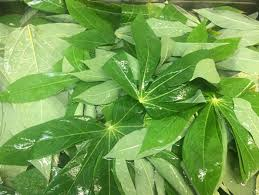

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/cassava-leaf-disease-classification/sample_submission.csv
/kaggle/input/cassava-leaf-disease-classification/label_num_to_disease_map.json
/kaggle/input/cassava-leaf-disease-classification/train.csv
/kaggle/input/cassava-leaf-disease-classification/train_tfrecords/ld_train14-1338.tfrec
/kaggle/input/cassava-leaf-disease-classification/train_tfrecords/ld_train13-1338.tfrec
/kaggle/input/cassava-leaf-disease-classification/train_tfrecords/ld_train04-1338.tfrec
/kaggle/input/cassava-leaf-disease-classification/train_tfrecords/ld_train01-1338.tfrec
/kaggle/input/cassava-leaf-disease-classification/train_tfrecords/ld_train08-1338.tfrec
/kaggle/input/cassava-leaf-disease-classification/train_tfrecords/ld_train00-1338.tfrec
/kaggle/input/cassava-leaf-disease-classification/train_tfrecords/ld_train10-1338.tfrec
/kaggle/input/cassava-leaf-disease-classification/train_tfrecords/ld_train02-1338.tfrec
/kaggle/input/cassava-leaf-disease-classification/train_tfrecords/ld_train15-1327.tf

## Import Libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import os
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Input, Reshape, MaxPooling2D, Flatten, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from IPython.display import Image
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import save_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
import warnings
warnings.filterwarnings('ignore')

In [10]:
df=pd.read_csv('/kaggle/input/cassava-leaf-disease-classification/train.csv')
#Reading the file.

In [11]:
df.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [12]:
df.columns=['img','label']
#Renaming the columns.

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21397 entries, 0 to 21396
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   img     21397 non-null  object
 1   label   21397 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 334.5+ KB


In [14]:
df['label']=df['label'].astype(str)

In [15]:
d={"0":"Cassava Bacterial Blight","1":"Cassava Brown Streak Disease","2":"Cassava Green Mottle","3":"Cassava Mosaic Disease","4":"Healthy"}

In [16]:
df['encode_label']=df['label'].map(d)

In [17]:
df['encode_label'].unique()

array(['Cassava Bacterial Blight', 'Cassava Mosaic Disease',
       'Cassava Brown Streak Disease', 'Cassava Green Mottle', 'Healthy'],
      dtype=object)

In [18]:
df.sample(5)

,img,label,encode_label
16649,3994869632.jpg,4,Healthy
6294,212828935.jpg,3,Cassava Mosaic Disease
13907,3485950795.jpg,4,Healthy
826,1141275049.jpg,3,Cassava Mosaic Disease
19880,70951614.jpg,3,Cassava Mosaic Disease


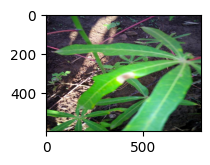

In [5]:
p='/kaggle/input/cassava-leaf-disease-classification/train_images/1001320321.jpg'
plt.figure(figsize=(2,2))
plt.imshow(plt.imread(p))
plt.show()

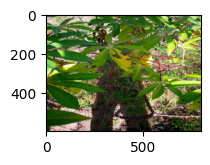

In [6]:
p='/kaggle/input/cassava-leaf-disease-classification/train_images/1000015157.jpg'
plt.figure(figsize=(2,2))
plt.imshow(plt.imread(p))
plt.show()

In [19]:
df['label']=df['label'].astype(int)

In [20]:
base_path = '/kaggle/input/cassava-leaf-disease-classification/train_images/'

df['img'] = base_path + df['img']

#There was no path to the images in the given csv file, so we added the url to the beginning.

In [21]:
x=[]
for img in df['img']:
    img=cv2.imread(img)
    img=cv2.resize(img,(32,32))
    img=img/255.0
    x.append(img)

## Modelling

In [22]:
x=np.array(x)

In [23]:
y=df['label']

In [24]:
df['label'].nunique()

5

In [25]:
print(len(x))
print(len(y))

21397
21397


In [26]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.20,random_state=42)

In [27]:
from keras.utils import to_categorical

y_train = to_categorical(y_train, num_classes=5)
y_test = to_categorical(y_test, num_classes=5)

In [28]:
model=Sequential()
model.add(Input(shape=(32,32,3)))
model.add(Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(128))
model.add(Dropout(0.2))
model.add(Dense(5,activation='softmax'))
early_stopping=EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

In [29]:
history=model.fit(x_train,y_train,epochs=25,verbose=1,validation_data=(x_test,y_test),callbacks=[early_stopping])

Epoch 1/25
535/535 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.6129 - loss: 1.1399 - val_accuracy: 0.6521 - val_loss: 1.0201
Epoch 2/25
535/535 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.6467 - loss: 1.0046 - val_accuracy: 0.6519 - val_loss: 0.9864
Epoch 3/25
535/535 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.6531 - loss: 0.9633 - val_accuracy: 0.6558 - val_loss: 0.9573
Epoch 4/25
535/535 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.6602 - loss: 0.9349 - val_accuracy: 0.6493 - val_loss: 1.0326
Epoch 5/25
535/535 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - accuracy: 0.6666 - loss: 0.9153 - val_accuracy: 0.6624 - val_loss: 0.9672
Epoch 6/25
535/535 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.6793 - loss: 0.8675 - val_accuracy: 0.6668 - val_loss: 0.9389
Epoch 7/25
535/535 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.6941 - loss: 0.8326 - val_accuracy: 0.6458 - val_loss: 1.0019
Epoch 8/25
535/535 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.7122 - loss: 0.7745 - 

In [30]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 945,233 (3.61 MB)

 Trainable params: 315,077 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 630,156 (2.40 MB)

In [31]:
loss,accuracy=model.evaluate(x_test, y_test)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5947 - loss: 1.6523
Test Loss: 1.6743062734603882
Test Accuracy: 0.5845794677734375


In [32]:
pred=model.predict(x_test)

134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


In [33]:
y_test = np.argmax(y_test, axis=1)
pred = np.argmax(pred, axis=1)

In [34]:
confusion_matrix(y_test,pred)

array([[  53,   35,   20,   48,   54],
       [  53,   89,   44,  148,  101],
       [  20,   22,  100,  230,   92],
       [  50,   66,  236, 2130,  192],
       [  51,   41,   87,  188,  130]])

In [35]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.23      0.25      0.24       210
           1       0.35      0.20      0.26       435
           2       0.21      0.22      0.21       464
           3       0.78      0.80      0.79      2674
           4       0.23      0.26      0.24       497

    accuracy                           0.58      4280
   macro avg       0.36      0.35      0.35      4280
weighted avg       0.58      0.58      0.58      4280



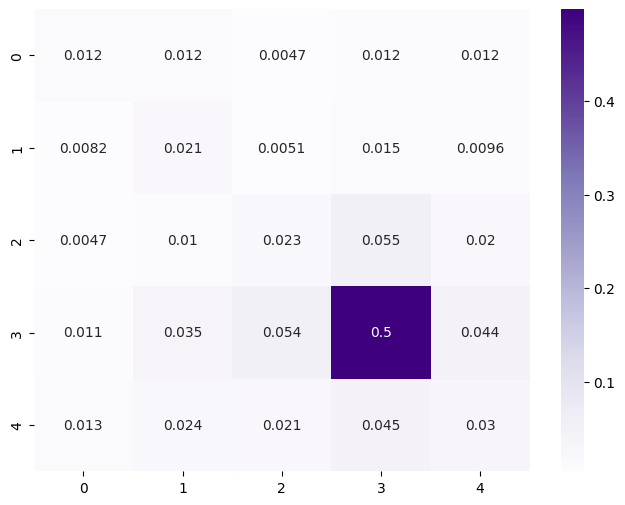

In [36]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(pred, y_test)
normalized_cm=cm / cm.sum()
sns.heatmap(normalized_cm, annot=True, cmap='Purples',annot_kws={"size": 10});

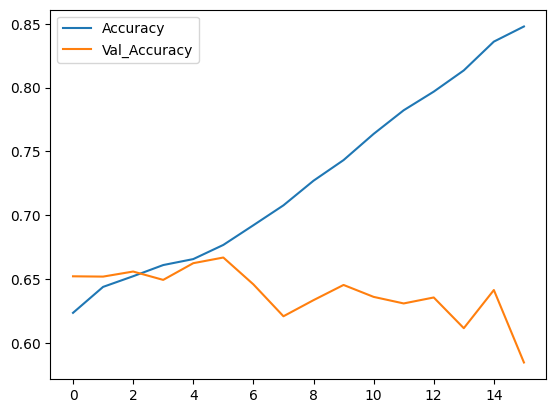

In [37]:
plt.plot(history.history['accuracy'],label='Accuracy')
plt.plot(history.history['val_accuracy'],label='Val_Accuracy')
plt.legend()

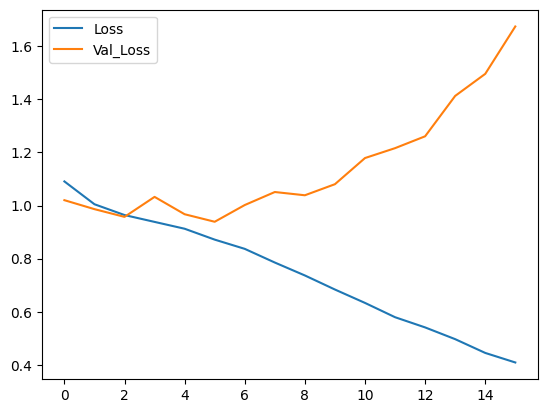

In [38]:
plt.plot(history.history['loss'],label='Loss')
plt.plot(history.history['val_loss'],label='Val_Loss')
plt.legend();

In [39]:
model.save('cassava.h5')

## Summary

In this project, we developed a Convolutional Neural Network (CNN) model to classify cassava images into four disease categories or a fifth category indicating a healthy leaf. Our project process includes the following steps:

Data Preparation: We added URLs to read the images in the CSV file and encoded the labels.
Model Training: We trained the model using CNN architecture and made various hyperparameter adjustments to increase its efficiency.
Performance Evaluation: We created a confusion matrix and class report to evaluate the success of the model.
Graph Analysis: We examined the graphs to visualize the training process and model performance.
Model Registration: We saved the trained model and made it ready for further use.
This study helps farmers quickly identify diseased plants, which is an important step towards preventing crop loss.